In [1]:
%matplotlib inline
import os

import cftime

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import cmocean

import cartopy
import cartopy.crs as ccrs

import esmlab

import intake
import intake_esm
import ncar_jobqueue
from dask.distributed import Client
from pint import UnitRegistry

units = UnitRegistry()
units.define('micromoles_per_kilogram = umol / kg') # used in WOA datasets

%load_ext watermark
%watermark -a "Mike Levy" -d -iv -m -g -h

cmocean       2.0
xarray        0.14.0
ncar_jobqueue 2019.10.16.1
numpy         1.17.3
cartopy       0.17.0
esmlab        2019.4.27.post55
cftime        1.0.3.4
intake_esm    2019.10.15.post40
intake        0.5.3
matplotlib    3.1.2
Mike Levy 2019-11-25 

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
host name  : casper21
Git hash   : 5cbdecb147018210e32eadb064235f187d74db83


In [2]:
cluster = ncar_jobqueue.NCARCluster(project='P93300606')
client = Client(cluster)
client

Client Scheduler: tcp://128.117.181.227:44421 Dashboard: https://jupyterhub.ucar.edu/dav/user/mlevy/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
cluster.scale(4)

In [4]:
def _read_var(dq, time_slice, variable):
    # Define datasets
    dataset = dq['ocn.historical.pop.h']

    keep_vars = ['REGION_MASK', 'z_t', 'dz', 'TAREA', 'TLONG', 'TLAT', 'time', 'time_bound', 'member_id', 'ctrl_member_id'] + [variable]
    dataset = dataset.drop([v for v in dataset.variables if v not in keep_vars]).sel(time=time_slice).mean(dim=['member_id', 'time'])

    return(dataset.isel(z_t=0))

In [5]:
def read_WOA(variable):
    woa_root=os.path.join(os.path.sep, 'glade', 'p', 'cgd', 'oce', 'projects',
                          'cesm2-marbl', 'woa2018-data', 'POP_gx1v7', 'annual')
    varmap = {'NO3' : 'n', 'PO4' : 'p', 'SiO3' : 'i'}
    filename=f'woa18_all_{varmap[variable]}00_gx1v7.nc'
    da=xr.open_dataset(os.path.join(woa_root, filename), decode_times=False).isel(time=0, z_t=0)[variable]
    return(da.data * units[da.attrs['units']])

In [29]:
for variable in ['NO3', 'PO4', 'SiO3']:
    obs[variable]=read_WOA(variable)*(1026*units['kg/m^3'])

In [12]:
%%time

catalog = intake.open_esm_datastore('/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/campaign-cesm2-cmip6-timeseries.json')

da = dict()
ds = dict()
obs=dict()
for variable in ['NO3', 'PO4', 'SiO3']:
    dq = catalog.search(experiment='historical', component='ocn', variable=variable).to_dataset_dict(cdf_kwargs={'chunks':{'time': 48}})
    ds[variable] = _read_var(dq, slice("1981-01-15", "2010-01-15"), variable)
    da_tmp = ds[variable][variable].compute()
    da[variable] = (da_tmp.data * units[ds[variable][variable].attrs['units']])
    obs[variable]=read_WOA(variable)*(1026*units['kg/m^3'])

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'

--> There will be 1 group(s)
CPU times: user 1min 18s, sys: 9.86 s, total: 1min 28s
Wall time: 13min 30s


In [56]:
from matplotlib.colors import BoundaryNorm

In [73]:
def plot_surface_vals(variable, ds, da, obs):
    TLONG = ds[variable].TLONG
    TLAT = ds[variable].TLAT
    computed = da[variable]
    observed = obs[variable]   
    bias=computed-observed # convert to /vol rather than /mass

    # Determine contours
    min_lev = 0
    if variable == 'NO3':
        max_lev = 42
    if variable == 'PO4':
        max_lev = 3.2
    if variable == 'SiO3':
        max_lev = 180
    levels = MaxNLocator(nbins=15).tick_values(min_lev, max_lev)
    cmap = plt.get_cmap('rainbow')
    norm = BoundaryNorm(levels, ncolors=cmap.N)

    fig = plt.figure(figsize=(8, 14))
    ax = plt.subplot(3, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))

    pc = ax.pcolormesh(TLONG,
                       TLAT,
                       computed.to('mmol/m^3').magnitude,
                       cmap=cmap,
                       transform=ccrs.PlateCarree(),
                       norm=norm)

    # ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
    #                                                    edgecolor='face',
    #                                                    facecolor='lightgray'))
    ax.set_global() 
    ax.coastlines(linewidth=0.5)
    cb = plt.colorbar(pc, shrink=0.6)
    ax.set_title(f'{variable} from POP run');
    cb.set_label('$\mathrm{mmol/m^3}$')

    ax = plt.subplot(3, 1, 2, projection=ccrs.Robinson(central_longitude=305.0))

    pc = ax.pcolormesh(TLONG,
                       TLAT,
                       observed.to('mmol/m^3').magnitude,
                       cmap=cmap,
                       transform=ccrs.PlateCarree(),
                       norm=norm)

    # ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
    #                                                    edgecolor='face',
    #                                                    facecolor='lightgray'))
    ax.set_global() 
    ax.coastlines(linewidth=0.5)
    cb = plt.colorbar(pc, shrink=0.6)
    ax.set_title(f'{variable} from WOA');
    cb.set_label('$\mathrm{mmol/m^3}$')
    
    ax = plt.subplot(3, 1, 3, projection=ccrs.Robinson(central_longitude=305.0))

    pc = ax.pcolormesh(TLONG,
                       TLAT,
                       bias.to('mmol/m^3').magnitude,
                       cmap=plt.get_cmap('bwr'),
                       transform=ccrs.PlateCarree())

    # ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
    #                                                    edgecolor='face',
    #                                                    facecolor='lightgray'))
    ax.set_global() 
    ax.coastlines(linewidth=0.5)
    cb = plt.colorbar(pc, shrink=0.6)
    ax.set_title(f'Bias in {variable}');
    cb.set_label('$\mathrm{mmol/m^3}$')


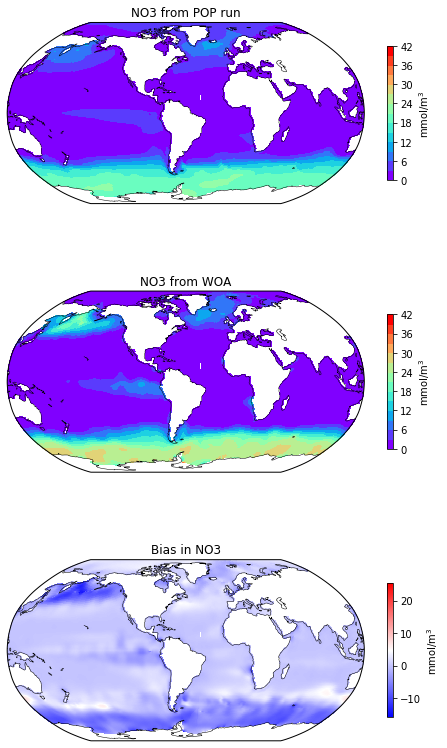

In [74]:
plot_surface_vals('NO3', ds, da, obs)

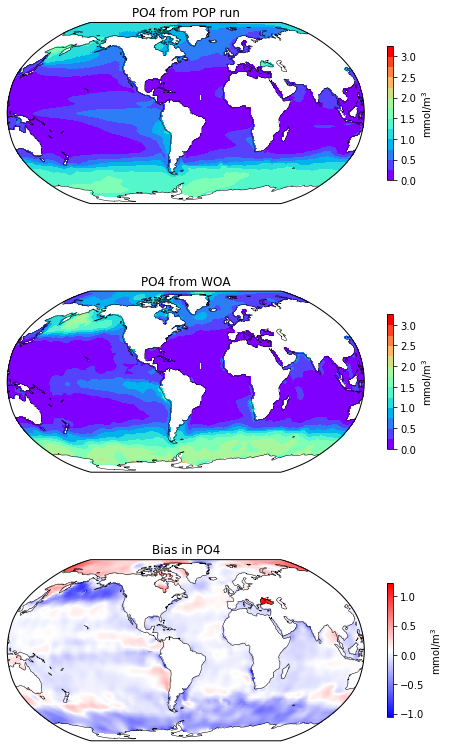

In [75]:
plot_surface_vals('PO4', ds, da, obs)

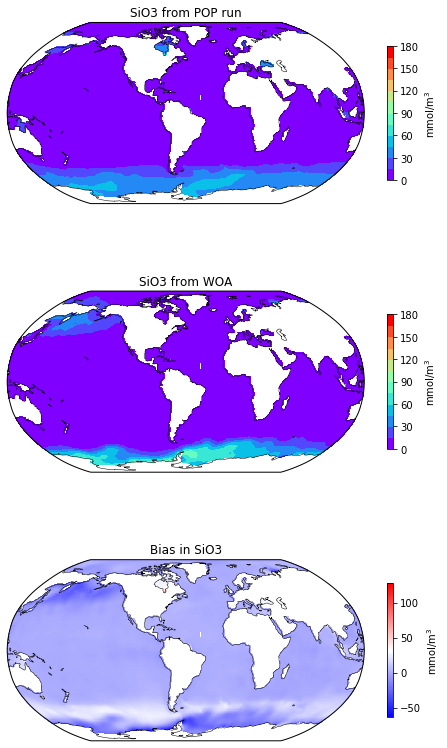

In [76]:
plot_surface_vals('SiO3', ds, da, obs)